# Self-attention

In [17]:
import torch
from torch.nn import *

class SelfAttention(Module):

    def __init__(self, feature_size):
        super().__init__()
        self.qry_layer = Linear(in_features=feature_size, out_features=feature_size) # 7B, 14B, 
        self.key_layer = Linear(in_features=feature_size, out_features=feature_size)
        self.val_layer = Linear(in_features=feature_size, out_features=feature_size)

    def forward(self, inp):
        
        Q = self.qry_layer(inp) # encoder(embedding) -> encoding
        K = self.key_layer(inp)
        V = self.val_layer(inp)        

        scores = torch.matmul(Q, K.T) / torch.sqrt(torch.tensor(inp.size(-1), dtype=torch.float32))
        attention_weights = functional.softmax(scores, dim = 1)
        context = torch.matmul(attention_weights, V)

        return context, attention_weights

selfattention = SelfAttention(feature_size=4)
input = torch.rand(5, 4)
context, attention_weights = selfattention(input)
attention_weights

tensor([[0.2010, 0.2574, 0.1963, 0.1675, 0.1779],
        [0.2035, 0.2568, 0.1914, 0.1719, 0.1764],
        [0.2017, 0.2536, 0.1954, 0.1704, 0.1789],
        [0.2029, 0.2438, 0.1969, 0.1734, 0.1830],
        [0.2019, 0.2473, 0.1965, 0.1730, 0.1814]], grad_fn=<SoftmaxBackward0>)

# Positional Encoding


POSITIONAL ENCODING PATTERN
d_model = 64
seq_length = 100
Number of frequency pairs: 32
Positional Encoding Matrix Shape: torch.Size([100, 64])


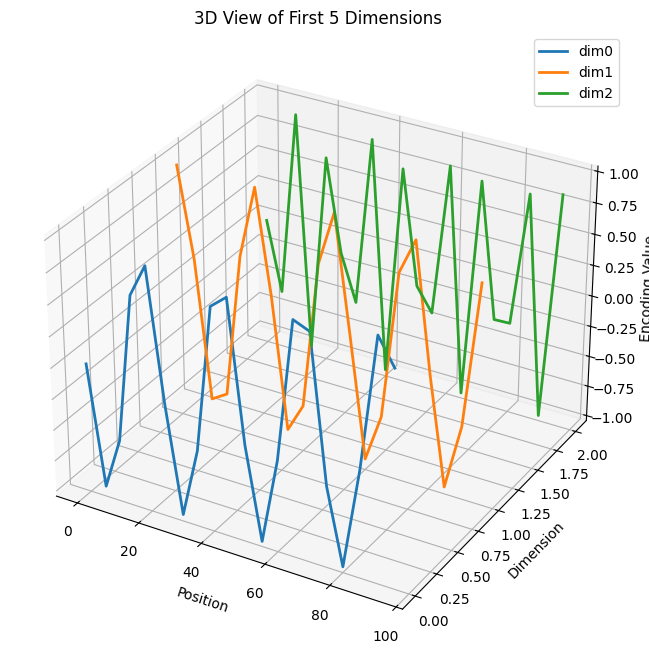

In [11]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

def show_positional_encoding_pattern():
    print(f"\n" + "="*60)
    print("POSITIONAL ENCODING PATTERN")
    print("="*60)
    
    d_model = 64
    seq_length = 100
    
    # Calculate div_term
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                        (-math.log(10000.0) / d_model))
    
    print(f"d_model = {d_model}")
    print(f"seq_length = {seq_length}")
    print(f"Number of frequency pairs: {len(div_term)}")
    
    # Create positional encoding matrix
    pe = torch.zeros(seq_length, d_model)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    
    # Calculate angles for each position and dimension
    angles = position * div_term
    
    # Apply sin/cos
    pe[:, 0::2] = torch.sin(angles)  # Even dimensions
    pe[:, 1::2] = torch.cos(angles)  # Odd dimensions
    
    print(f"Positional Encoding Matrix Shape: {pe.shape}")
    
    # Create comprehensive visualization
    create_positional_encoding_plot(pe, d_model, seq_length)
    
    return pe


from mpl_toolkits.mplot3d import Axes3D

def create_positional_encoding_plot(pe, d_model, seq_length):
    """Create 3D plot to visualize positional encoding patterns"""
    
    # Convert to numpy for plotting
    pe_np = pe.numpy()
    positions = np.arange(seq_length)
    dims_3d = min(3, d_model)
    pos_sample = positions[::5]  # Sample positions for clarity
    pe_sample = pe_np[::5]

    # Create figure with 3D subplot
    fig = plt.figure(figsize=(12, 8))    
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(dims_3d):
        ax.plot(pos_sample, [i]*len(pos_sample), pe_sample[:, i], 
                label=f'dim{i}', linewidth=2) 
    
    ax.set_xlabel('Position')      
    ax.set_ylabel('Dimension')     
    ax.set_zlabel('Encoding Value') 
    ax.set_title('3D View of First 5 Dimensions')
    ax.legend()
    
    plt.show()
    

if __name__ == "__main__":    
    pe = show_positional_encoding_pattern()

# Transformer

In [24]:
class SimpleTransformer(Module):

    def __init__(self, seq_len, d_model, num_heads, dim_ff, num_layers, device):
        super().__init__()

        self.seq_len, self.d_model = seq_len, d_model
        self.device = device

        self.pos_enc = self.positional_encoding(seq_len, d_model, device)

        self.layers = ModuleList([self.EncoderLayer(d_model, num_heads, dim_ff) for _ in range(num_layers)])


    def positional_encoding(self, seq_len, d_model, device):

        pe = torch.zeros(seq_len, d_model) # 0 bilan initialization
        position = torch.arange(0, seq_len, dtype=torch.float, device = device).unsqueeze(1)        
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -math.log(10000) / d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe
    
    class EncoderLayer(Module):
        def __init__(self, d_model, num_heads, dim_ff):
            super().__init__()

            self.attn = MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
            self.ff = Sequential(Linear(d_model, dim_ff), ReLU(), Linear(dim_ff, d_model))

            self.norm1 = LayerNorm(d_model)
            self.norm2 = LayerNorm(d_model)

        def forward(self, inp):

            attn_out, attn_weights = self.attn(inp, inp, inp)
            inp = self.norm1(inp + attn_out)
            ff_out = self.ff(inp)
            inp = self.norm2(inp + ff_out)

            return inp, attn_weights
        
    def forward(self, inp, show_steps = True):

        if show_steps: print(f"input shape -> {inp.shape}")

        inp = inp + self.pos_enc.unsqueeze(0)

        if show_steps: print(f"after pos encoding shape -> {inp.shape}")

        all_attn_weights = []

        for i, layer in enumerate(self.layers):

            inp, attn_weights = layer(inp)
            all_attn_weights.append(attn_weights)        
            if show_steps:
                print(f"inp After layer {i+1} -> {inp.shape}")
                print(f"attn_weights After layer {i+1} -> {attn_weights.shape}")

        return inp, all_attn_weights       

In [25]:
misol = "I love Natural Language Processing"
print(f"Misol -> {misol}")

tokenlar = misol.lower().split()
print("Tokenlar:", tokenlar)

torch.manual_seed(0)

# Lug'at
lugat = {soz: torch.randn(4) for soz in tokenlar}
print(f"lugat -> {lugat}")

# so'zlardan embeddinglar yaratish
embeddinglar = torch.stack([lugat[token] for token in tokenlar])

print("Embeddinglar hajmi:", embeddinglar.shape)  # Should be (seq_len, d_model)
print("'love' uchun embeddinglar :", lugat['love'])

input_misol = embeddinglar.unsqueeze(0)  # now shape (1, seq_len, d_model)
print("Input tensor hajmi:", input_misol.shape)

Misol -> I love Natural Language Processing
Tokenlar: ['i', 'love', 'natural', 'language', 'processing']
lugat -> {'i': tensor([ 1.5410, -0.2934, -2.1788,  0.5684]), 'love': tensor([-1.0845, -1.3986,  0.4033,  0.8380]), 'natural': tensor([-0.7193, -0.4033, -0.5966,  0.1820]), 'language': tensor([-0.8567,  1.1006, -1.0712,  0.1227]), 'processing': tensor([-0.5663,  0.3731, -0.8920, -1.5091])}
Embeddinglar hajmi: torch.Size([5, 4])
'love' uchun embeddinglar : tensor([-1.0845, -1.3986,  0.4033,  0.8380])
Input tensor hajmi: torch.Size([1, 5, 4])


In [26]:
device = 'cpu'

# Parameters consistent with embedding size and sequence length
seq_len = len(tokenlar)
d_model = 4
num_heads = 2
dim_ff = 8 # feed-forward hidden dimension
num_layers = 2

# Instantiate model
model = SimpleTransformer(seq_len, d_model, num_heads, dim_ff, num_layers, device)

# Forward pass with printout to show intermediate steps
output, all_attn_weights = model(input_misol, show_steps=True)

input shape -> torch.Size([1, 5, 4])
after pos encoding shape -> torch.Size([1, 5, 4])
inp After layer 1 -> torch.Size([1, 5, 4])
attn_weights After layer 1 -> torch.Size([1, 5, 5])
inp After layer 2 -> torch.Size([1, 5, 4])
attn_weights After layer 2 -> torch.Size([1, 5, 5])
